# Untitled Notebook

What's this notebook about?

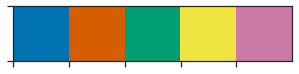

In [1]:
import sys
import re
import os
from glob import glob
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import upsetplot
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [29]:
def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


locus2gene = defaultdict(set)
with open('../../nanopore_apa_pipeline/pipeline/assembly/merged_nanopore_assembly.gtf') as gtf:
    for record in gtf:
        record = record.split('\t')
        if record[2] == 'transcript':
            locus_id = get_gtf_attribute(record, 'locus')
            gene_id = get_gtf_attribute(record, 'gene_id')
            if re.match('AT[1-5]G\d{5}', gene_id):
                locus2gene[locus_id].add(gene_id)

locus2gene = {k: ','.join(v) for k, v in locus2gene.items()}

In [46]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'nreads_cntrl', 'nreads_treat'
]

fpa_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)
fpa_vs_col0['gene_ids'] = fpa_vs_col0.locus_id.map(locus2gene)

FPAox_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)
FPAox_vs_col0['gene_ids'] = FPAox_vs_col0.locus_id.map(locus2gene)

vir1_vs_VIRc = pd.read_csv(
    '/cluster/ggs_lab/mtparker/nanopore_apa_pipeline/vir1_vs_VIRc/apa_results/vir1_vs_VIRc.apa_results.bed',
    sep='\t', names=RESULTS_COLUMNS
)
FPAox_vs_col0.head()

,chrom,start,end,locus_id,score,strand,wass_dist,wass_dir,wass_pval,wass_fdr,nreads_cntrl,nreads_treat,gene_ids
0,1,5885,13714,RLOC_00000002,384,-,383.6,-382.9,0.1620,0.473,66,89,"AT1G01030,AT1G01020"
1,1,31115,33315,RLOC_00000006,47,-,47.4,47.4,0.4910,0.773,208,324,AT1G01050
2,1,33364,37871,RLOC_00000008,25,-,24.8,-4.5,0.0852,0.391,189,336,AT1G01060
3,1,44797,49306,RLOC_00000011,30,-,30.1,-17.7,0.6100,0.844,774,953,AT1G01080
4,1,49908,51210,RLOC_00000012,36,-,36.4,-33.1,0.0253,0.233,2226,2866,AT1G01100


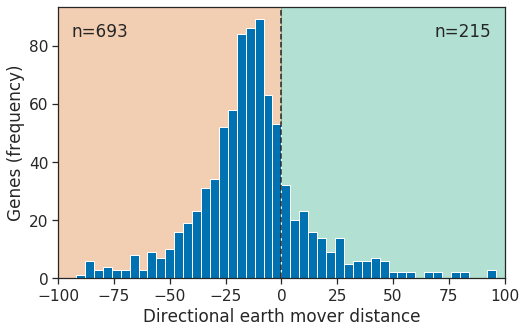

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

upper_bound=100
lower_bound=-100

sig = vir1_vs_VIRc.query('wass_fdr < 0.05')
ax.hist(sig.wass_dir, bins=50, range=(lower_bound, upper_bound))
ax.axvline(0, ls='--', color='#252525')
ax.axvspan(lower_bound, 0, color=pal[1], zorder=0, alpha=0.3)
ax.axvspan(0, upper_bound, color=pal[2], zorder=0, alpha=0.3)
ax.set_xlim(lower_bound, upper_bound)

n_prox = len(sig.query('wass_dir < 0'))
n_dist = len(sig.query('wass_dir > 0'))

ax.annotate(
    xy=(0.03, 0.89),
    s=f'n={n_prox}',
    xycoords='axes fraction'
)
ax.annotate(
    xy=(0.97, 0.89),
    s=f'n={n_dist}',
    ha='right',
    xycoords='axes fraction',
)
ax.set_xlabel('Directional earth mover distance')
ax.set_ylabel('Genes (frequency)')
plt.savefig('vir1_vs_VIRc.svg')
plt.show()

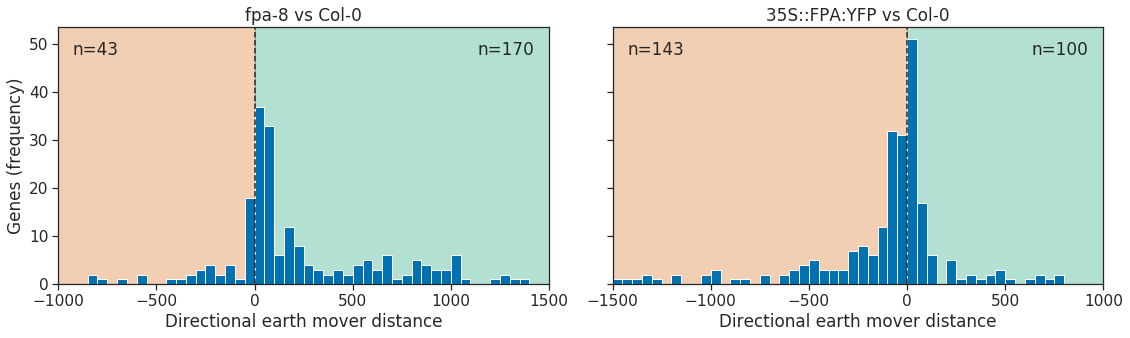

In [31]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2, sharey=True)

ax_it = zip(
    axes,
    [fpa_vs_col0, FPAox_vs_col0],
    [-1000, -1500],
    [1500, 1000],
    ['fpa-8 vs Col-0', '35S::FPA:YFP vs Col-0'],
)

for ax, df, lower_bound, upper_bound, title in ax_it:
    sig = df.query('wass_fdr < 0.05 & wass_dist > 25')
    ax.hist(sig.wass_dir, bins=50, range=(lower_bound, upper_bound))
    ax.axvline(0, ls='--', color='#252525')
    ax.axvspan(lower_bound, 0, color=pal[1], zorder=0, alpha=0.3)
    ax.axvspan(0, upper_bound, color=pal[2], zorder=0, alpha=0.3)
    ax.set_xlim(lower_bound, upper_bound)

    n_prox = len(sig.query('wass_dir < 0'))
    n_dist = len(sig.query('wass_dir > 0'))

    ax.annotate(
        xy=(0.03, 0.89),
        s=f'n={n_prox}',
        xycoords='axes fraction'
    )
    ax.annotate(
        xy=(0.97, 0.89),
        s=f'n={n_dist}',
        ha='right',
        xycoords='axes fraction',
    )
    ax.set_xlabel('Directional earth mover distance')
    ax.set_ylabel('')
    ax.set_title(title)
axes[0].set_ylabel('Genes (frequency)')
plt.tight_layout()
plt.savefig('figures/nanopore_fpa_35FPA_APA.svg')
plt.show()

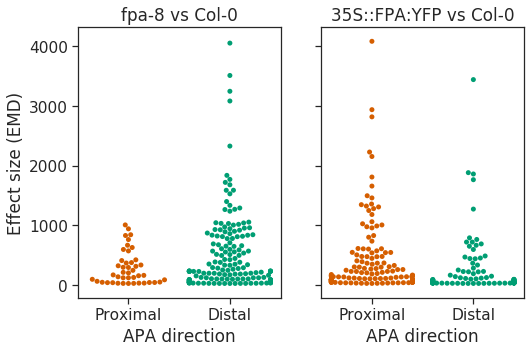

In [32]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

sns.swarmplot(
    x=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[0],
    palette=pal[1:3]
)

sns.swarmplot(
    x=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[1],
    palette=pal[1:3]
)
axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
#axes[0].set_ylim(-50, 1100)
axes[0].set_ylabel('Effect size (EMD)')
axes[1].set_ylabel('')
axes[0].set_xticklabels(['Proximal', 'Distal'])
axes[1].set_xticklabels(['Proximal', 'Distal'])
axes[0].set_xlabel('APA direction')
axes[1].set_xlabel('APA direction')
plt.show()

In [33]:
genes_tested_in_both = set(fpa_vs_col0.locus_id).intersection(FPAox_vs_col0.locus_id)
fpa_distal = set(fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
FPAox_proximal = set(FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)

print(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

10 9713 165 139


2.332553820740831e-05

In [39]:
nblrrs = pd.read_csv(
    '../annotations/nblrrs.txt',
    sep='\t',
)

rlps = pd.read_csv(
   '../annotations/rlps.txt',
    sep='\t'
)

nblrrs.head()

,gene_id,nblrr_class,locus_id
0,AT3G26470,C,RLOC_00017838
1,AT5G66630,CN-A,RLOC_00034872
2,AT1G52660,CN-B,RLOC_00005610
3,AT3G15700,CN-B,RLOC_00016497
4,AT4G19060,CN-C,RLOC_00024687


In [40]:
nblrrs[nblrrs.locus_id.isin(fpa_distal)]

,gene_id,nblrr_class,locus_id
30,AT5G63020,CNL-B5,RLOC_00034448
58,AT1G59218,CNL-D,RLOC_00006336
100,AT4G19530,TNL-B2,RLOC_00024743


In [41]:
nblrrs[nblrrs.locus_id.isin(FPAox_proximal)]

,gene_id,nblrr_class,locus_id
26,AT1G61300,CNL-B3,RLOC_00006565
49,AT5G48620,CNL-D,RLOC_00032750
55,AT1G58602,CNL-D,RLOC_00006322
57,AT1G58807,CNL-D,RLOC_00006328
58,AT1G59218,CNL-D,RLOC_00006336
59,AT1G58848,CNL-D,RLOC_00006328
74,AT4G16990,TN,RLOC_00024419
134,AT3G44670,TNL-G2,RLOC_00019477
135,AT3G44480,TNL-G2,RLOC_00019454
136,AT3G44630,TNL-G2,RLOC_00019472


In [42]:
rlps[rlps.locus_id.isin(fpa_distal)]

,gene_id,gene_name,locus_id


In [43]:
rlps[rlps.locus_id.isin(FPAox_proximal)]

,gene_id,gene_name,locus_id
29,AT3G05360,AtRLP30,RLOC_00015273


In [23]:
with pd.ExcelWriter('./nanopore_fpa8_35SFPA_alternative_polya.xlsx') as xl:
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='fpa8_distal')
    fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='fpa8_proximal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').to_excel(xl, sheet_name='35SFPA_distal')
    FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').to_excel(xl, sheet_name='35SFPA_proximal')